Run the following cells to prepare your working environment:

In [24]:
# !pip install -r requirements.txt
# !export PYTHONPATH="${PYTHONPATH}:$PWD"

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from model import *
from train import *

from dotmap import DotMap
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device is {}".format(device))

Device is cpu


## Part 2: Rescue the Randomness (Loss Functions)

### Data

In [5]:
n = 32                        # Dataset Size
sigma = 0.1                   # Noise Level

In [6]:
a = torch.arange(n, device=device)

inputs = torch.zeros(n,n, device=device)
inputs[torch.arange(n), a] = 1

raw_truths = torch.flip(inputs, dims=(1,))

inputs, raw_truths = inputs.unsqueeze(dim=1), raw_truths.unsqueeze(dim=1)

In [7]:
noise = torch.randn(n,1,n, device=device)*sigma
truths = raw_truths + noise

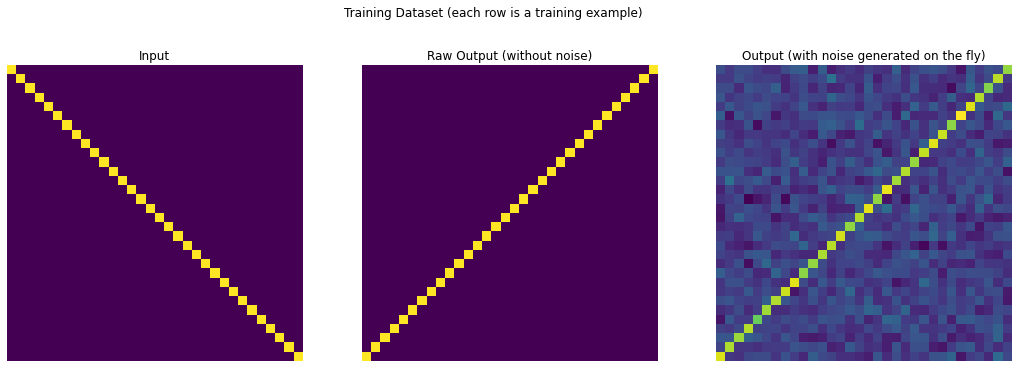

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))

fig.suptitle('Training Dataset (each row is a training example)')

axs[0].set_title('Input')
axs[1].set_title('Raw Output (without noise)')
axs[2].set_title('Output (with noise generated on the fly)')

axs[0].imshow(inputs.squeeze().cpu().numpy())
axs[1].imshow(raw_truths.squeeze().cpu().numpy())
axs[2].imshow(truths.squeeze().cpu().numpy())

[axi.set_axis_off() for axi in axs.ravel()]

plt.show()

In [9]:
inputs.shape, raw_truths.shape, truths.shape

(torch.Size([32, 1, 32]), torch.Size([32, 1, 32]), torch.Size([32, 1, 32]))

### Model

In [10]:
args = DotMap()

# Model
args.in_ch, args.out_ch = 1, 1
args.intermediate_ch = [4, 8, 8, 16, 16]
args.kernel_size = [3, 3, 3, 3, 3]
args.scale_depth, args.dilation = [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]
args.padding_mode = 'zeros' 

args.latent_num = 5
args.latent_chs = [1, 1, 1, 1, 1]
args.latent_locks = [False, False, False, False, False]


# Loss
args.rec_type = 'mse'
args.loss_type = 'elbo'
args.beta = 1.0
args.beta_asc_steps = None


# Training
args.epochs = 2
args.optimizer = 'adamax'
args.wd = 1e-5
args.lr = 1e-3
args.scheduler_type = 'cons'

In [15]:
# Initialize the Model
extra_out_ch = 1 if args.rec_type == 'loglikelihood' and args.ll_std_sample_num == 0 else 0

model = HPUNet( in_ch=args.in_ch, out_ch=args.out_ch+extra_out_ch, chs=args.intermediate_ch,
                latent_num=args.latent_num, latent_channels=args.latent_chs, latent_locks=args.latent_locks,
                scale_depth=args.scale_depth, kernel_size=args.kernel_size, dilation=args.dilation,
                padding_mode=args.padding_mode, conv_dim=1 )


args.trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


model.to(device)


# Set Loss Function

## Reconstruction Loss
if args.rec_type.lower() == 'mse':
    reconstruction_loss = MSELossWrapper()

elif args.rec_type.lower() == 'loglikelihood':
    reconstruction_loss = LogLikelihoodLoss()

else:
    print('Invalid reconstruction loss type, exiting...')
    exit()


## Total Loss
if args.loss_type.lower() == 'elbo':
    if args.beta_asc_steps is None:
        beta_scheduler = BetaConstant(args.beta)
    else:
        beta_scheduler = BetaLinearScheduler(ascending_steps=args.beta_asc_steps, constant_steps=args.beta_cons_steps, max_beta=args.beta, saturation_step=args.beta_saturation_step)
    criterion = ELBOLoss(reconstruction_loss=reconstruction_loss, beta=beta_scheduler).to(device)

elif args.loss_type.lower() == 'geco':
    kappa = args.kappa
    if args.kappa_px is True:
        kappa *= n
    criterion = GECOLoss(reconstruction_loss=reconstruction_loss, kappa=kappa, decay=args.decay, update_rate=args.update_rate, device=device).to(device)

else:
    print('Invalid loss type, exiting...')
    exit()


# Set Optimizer
if args.optimizer == 'adamax':
    optimizer = optim.Adamax(model.parameters(), lr=args.lr, weight_decay=args.wd)

elif args.optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)

elif args.optimizer == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.wd)

else:
    print('Optimizer not known, exiting...')
    exit()


# Set LR Scheduler
if args.scheduler_type == 'cons':
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.epochs)

elif args.scheduler_type == 'step':
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.scheduler_step_size, gamma=args.scheduler_gamma)

elif args.scheduler_type == 'milestones':
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=args.scheduler_milestones, gamma=args.scheduler_gamma)

### Training

In [16]:
# Generate Stamp
stamp = 'beta = 1'

# Initialize SummaryWriter (for tensorboard)
writer = SummaryWriter('runs/part2/{}/tb'.format(stamp))

In [ ]:
def record_history(idx, loss_dict, type='train'):
    prefix = 'Minibatch Training ' if type == 'train' else 'Mean Validation '

    loss_per_pixel = loss_dict['loss'].item() / args.pixels
    reconstruction_per_pixel = loss_dict['reconstruction_term'].item() / args.pixels
    kl_term_per_pixel = loss_dict['kl_term'].item() / args.pixels
    kl_per_pixel = [ loss_dict['kls'][v].item() / args.pixels for v in range(args.latent_num) ]

    # Total Loss
    _dict = {   'total': loss_per_pixel,
                'kl term': kl_term_per_pixel, 
                'reconstruction': reconstruction_per_pixel  }
    writer.add_scalars(prefix + 'Loss Curve', _dict, idx)
    
    # Reconstruction Term Decomposition
    if args.rec_type.lower() == 'loglikelihood':
        _dict = {   'reconstruction term mse': loss_dict['recterm_mse'].item() / args.pixels,
                    'reconstruction term std': loss_dict['recterm_std'].item() / args.pixels   }
        writer.add_scalars(prefix + 'Loss Curve (Reconstruction)', _dict, idx)

    # KL Term Decomposition
    _dict = { 'sum': sum(kl_per_pixel) }
    _dict.update( { 'scale {}'.format(v): kl_per_pixel[v] for v in range(args.latent_num) } )
    writer.add_scalars(prefix + 'Loss Curve (K-L)', _dict, idx)

    # Coefficients
    if type == 'train':
        if args.loss_type.lower() == 'elbo':
            writer.add_scalar('Beta', criterion.beta_scheduler.beta, idx)
        elif args.loss_type.lower() == 'geco':
            writer.add_scalar('Lagrange Multiplier', criterion.log_inv_function(criterion.log_lamda).item(), idx)

In [23]:
model.train()
criterion.train()

for e in range(args.epochs):
    # Initialization
    
    model.zero_grad()
    
    # Train One Step
    print('alive3')
    
    ## Generate Truths
    noise = torch.randn(n,1,n, device=device)*sigma
    truths = raw_truths + noise
    
    print('alive2')
    ## Get Predictions and Prepare for Loss Calculation
    if args.rec_type.lower() == 'mse':
        print('alive')
        preds, infodicts = model(inputs, truths)
        preds, infodict = preds[:,0], infodicts[0]
        logstd2 = None

    elif args.rec_type.lower() == 'loglikelihood':
        if args.ll_std_sample_num == 0:
            preds, infodicts = model(inputs, truths, first_channel_only=False)
            preds, logstd2, infodict = preds[:,0,0], preds[:,0,1], infodicts[0]

        elif args.ll_std_sample_num > 0:
            preds, infodicts = model(inputs, truths, times=args.ll_std_sample_num)
            # with torch.no_grad():
            logstd2 = torch.log( torch.var(preds, dim=1, unbiased=True) )  # or preds.detach()
            k = randrange(args.ll_std_sample_num)
            preds, infodict = preds[:,k], infodicts[k]

    truths = truths.squeeze(dim=1)
    
    
    ## Calculate Loss
    loss = criterion(preds, truths, kls=infodict['kls'], logstd2=logstd2, lr=lr_scheduler.get_last_lr()[0])


    ## Backpropagate
    loss.backward()             # Calculate Gradients
    optimizer.step()            # Update Weights


    ## Step Beta Scheduler
    if args.loss_type.lower() == 'elbo':
        criterion.beta_scheduler.step()


    # Record Train History
    loss_dict = criterion.last_loss.copy()
    loss_dict.update( { 'kls': infodict['kls'] } )

    if args.rec_type.lower() == 'loglikelihood':
        if isinstance(criterion.reconstruction_loss, TopkMaskedLoss):
            ll_loss_internal = criterion.reconstruction_loss.loss.last_loss
        else:
            ll_loss_internal = criterion.reconstruction_loss.last_loss

        loss_dict.update( { 'recterm_mse': ll_loss_internal['expanded_mse_term'].sum(dim=(1,2)).mean(),
                            'recterm_std': ll_loss_internal['expanded_std_term'].sum(dim=(1,2)).mean() } )

    record_history(idx, loss_dict)

alive3
alive2
alive
alive
x: torch.Size([32, 32])
y: (1, 2)


NameError: name 'record_history' is not defined